In [1]:
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.model_selection import train_test_split
from netCDF4 import Dataset

with Dataset("simObsCrossTrack_2dn_extended.nc") as fh:
    yobsL=fh["tb"][:,:]
    iwc_SSRG=fh["iwc_SSRG"][:,:]
    iwc_CS=fh["iwcCS"][:,:]
    zKu=fh["zKu"][:,:]
    pnorm=fh["pnorm"][:,:]
    pmol=fh["pmol"][:,:]

iwpL=[]
iwc_gcL=[]
h=np.arange(50)*0.24
import tqdm
iwc_SSRGL=[]
zKuL=[]
pnormL=[]
tbObsL=[]
for i,iwc in tqdm.tqdm(enumerate(iwc_SSRG)):
    if(iwc.sum()>0.01):
        a=np.nonzero(iwc>0.001)
        if len(a[0])>2:
            iwpL.append(iwc.sum()*0.24)
            hgc1=(iwc[a]*h[a]).sum()/iwc[a].sum()
            iwc_gcL.append(hgc1)
            iwc_SSRGL.append(iwc)
            zKuL.append(zKu[i])
            pnormL.append(pnorm[i])
            tbObsL.append(yobsL[i])

#set random seed
np.random.seed(42)
tbObsL=np.array(tbObsL)
iwpL=np.array(iwpL)
iwc_gcL=np.array(iwc_gcL)
iwc_SSRGL=np.array(iwc_SSRGL)
zKuL=np.array(zKuL)
pnormL=np.array(pnormL)

nt,nchan=tbObsL.shape   
lidarNoise=np.random.randn(nt,50)*0.1
pnorm=np.log10(1e-3*(pnormL)*10**lidarNoise+1e-9)  #add noise to pnorm
# pnorm is in sr^-1 m^-1 units
pnorm[pnorm<-8.0]=-8.0
pnormMax=pnorm.max(axis=-1)
nt2,nchan=yobsL.shape

zKuL+=np.random.randn(nt,50)
zKuL[zKuL<8]=0
print(nt/nt2)



838280it [00:31, 26373.54it/s]


0.7876986209858281


In [2]:
print(nt)
nt=tbObsL.shape[0]
tbObsL+=np.random.randn(nt,nchan)*3


660312


In [3]:
#import train_test_split
from sklearn.model_selection import train_test_split
nt=tbObsL.shape[0]
yobsLidarRadar=np.concatenate((pnorm,zKuL),axis=-1)
ind_train,ind_test,y_train, y_test = train_test_split(range(nt), iwc_SSRGL[:].sum(axis=-1)*0.24, test_size=0.33, random_state=42)
nt,nc=yobsL.shape

X1_train=yobsLidarRadar[ind_train,:]
X1_test=yobsLidarRadar[ind_test,:]
iwc_train=iwc_SSRGL[ind_train,:]
iwp_train=iwc_train.sum(axis=-1)*0.24
iwc_test=iwc_SSRGL[ind_test,:]
iwp_test=iwc_test.sum(axis=-1)*0.24
iwc_gc_train=iwc_gcL[ind_train]
iwc_gc_test=iwc_gcL[ind_test]

In [4]:
# import lightgbm as lgb
import lightgbm as lgb
lgbmReg_IWP=lgb.LGBMRegressor(n_estimators=1000,learning_rate=0.01,num_leaves=200,objective="mse",random_state=42)
lgbmReg_IWP.fit(X1_train,iwp_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20293
[LightGBM] [Info] Number of data points in the train set: 442409, number of used features: 90
[LightGBM] [Info] Start training from score 0.234342


LGBMRegressor(learning_rate=0.01, n_estimators=1000, num_leaves=200,
              objective='mse', random_state=42)

[[1.         0.89642174]
 [0.89642174 1.        ]]


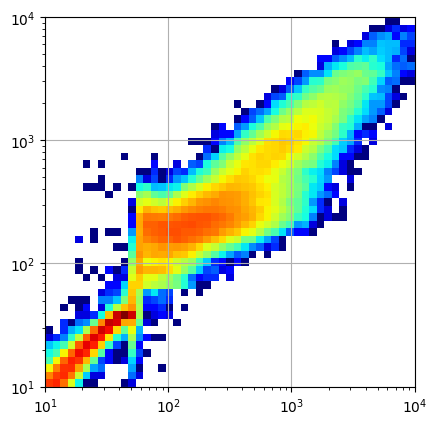

In [5]:
y_pred=lgbmReg_IWP.predict(X1_test)
print(np.corrcoef(y_pred,iwp_test))
import matplotlib.pyplot as plt
import matplotlib
xbins=np.logspace(1,4,50)
plt.figure()
ax=plt.subplot(111)
plt.hist2d(iwp_test*1e3,y_pred*1e3,bins=xbins,norm=matplotlib.colors.LogNorm(),cmap="jet")
plt.xscale('log')
plt.yscale('log')
ax.set_aspect('equal')
plt.grid()

In [6]:
import lightgbm as lgb
lgbmReg_IWC_GC=lgb.LGBMRegressor(n_estimators=1000,learning_rate=0.01,num_leaves=200,objective="mse",random_state=42)
lgbmReg_IWC_GC.fit(X1_train,iwc_gc_train)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20293
[LightGBM] [Info] Number of data points in the train set: 442409, number of used features: 90
[LightGBM] [Info] Start training from score 5.190720


LGBMRegressor(learning_rate=0.01, n_estimators=1000, num_leaves=200,
              objective='mse', random_state=42)

[[1.       0.982914]
 [0.982914 1.      ]]


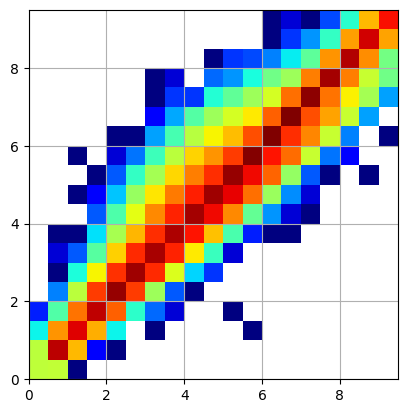

In [7]:
y_pred_gc=lgbmReg_IWC_GC.predict(X1_test)
print(np.corrcoef(y_pred_gc,iwc_gc_test))
import matplotlib.pyplot as plt
import matplotlib
xbins=np.logspace(1,4,50)
plt.figure()
ax=plt.subplot(111)
plt.hist2d(iwc_gc_test,y_pred_gc,bins=np.arange(20)*0.5,norm=matplotlib.colors.LogNorm(),cmap="jet")
ax.set_aspect('equal')
plt.grid()

In [8]:
import xarray as xr

y_predX=xr.DataArray(1e3*y_pred)
y_predX.name="iwp_pred"
y_predX.attrs["units"]="g/m^2"
y_predX.attrs["long_name"]="predicted ice water path"
iwp_testX=xr.DataArray(1e3*iwp_test)
iwp_testX.name="iwp_test"
iwp_testX.attrs["units"]="g/m^2"
iwp_testX.attrs["long_name"]="test ice water path"
iwc_gc_testX=xr.DataArray(iwc_gc_test)
iwc_gc_testX.name="iwc_gc_test"
iwc_gc_testX.attrs["units"]="km"
iwc_gc_testX.attrs["long_name"]="test IWC gravity center"
y_pred_gcX=xr.DataArray(y_pred_gc)
y_pred_gcX.name="iwc_gc_pred"
y_pred_gcX.attrs["units"]="km"
y_pred_gcX.attrs["long_name"]="predicted IWC gravity center"
ds=xr.merge([y_predX,iwp_testX,iwc_gc_testX,y_pred_gcX])
ds.to_netcdf("lgbm_IWP_IWC_GC_lidarRadar.nc")